In [ ]:
!pip install gensim nltk
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC
from scipy.sparse import hstack
import time
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix, make_scorer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Cleaning

In [ ]:
# --- 1. ARABIC PREPROCESSING UTILITIES ---

# Comprehensive list of Arabic diacritics (Harakat) to be removed
ARABIC_DIACRITICS = re.compile(r'[\u064B-\u0652]')

def remove_diacritics(text):
    """Removes Arabic diacritics (Harakat) from text."""
    return ARABIC_DIACRITICS.sub('', text)

def remove_non_alpha(text):
    """Removes non-alphanumeric characters except spaces."""
    # Keeps Arabic letters, English letters (if any), and spaces
    return re.sub(r'[^\w\s]', '', text)

def clean_text(text):
    """Applies basic cleaning and normalization."""
    if pd.isna(text) or not text:
        return ""
    text = str(text).lower()
    text = remove_diacritics(text)
    text = remove_non_alpha(text)
    return re.sub(r'\s+', ' ', text).strip() # Normalize whitespace

def calculate_morph_complexity(tokens_col):
    """
    Calculates the average number of morphological tokens (D3Tok/D3Lex) per original word.
    A higher value indicates more complex agglutination.
    """
    if pd.isna(tokens_col) or not tokens_col:
        return 1.0 # Default complexity for empty/missing data

    original_words = tokens_col.split()
    total_morph_units = 0
    total_words = 0

    for word in original_words:
        # Check for the '+' delimiter, which separates morphological units
        morph_units = word.count('+') + 1
        total_morph_units += morph_units
        total_words += 1

    return total_morph_units / total_words if total_words > 0 else 1.0

In [ ]:
# --- 2. DATA LOADING AND INITIAL CLEANING ---

FILEPATH = '/content/drive/MyDrive/bayyin_dataset.csv'

df = pd.read_csv(FILEPATH)

# Drop rows where the target or essential feature columns are missing
df.dropna(subset=['Sentence', 'Lex', 'Word_Count', 'Readability_Level'], inplace=True)

# Encode the target variable (Readability_Level) to integers (0 to 5)
target_le = LabelEncoder()
df['Readability_Level_Encoded'] = target_le.fit_transform(df['Readability_Level'])
print(f"Readability Levels Mapped to: {dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))}")

# Apply cleaning to the text columns
df['Clean_Lex'] = df['Lex'].apply(clean_text)

Readability Levels Mapped to: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(6): np.int64(5)}


# Feature Engineering

In [ ]:
# --- A. Core Linguistic/Statistical Features ---
print("Calculating statistical features...")
# 1. Word Count (already present, but ensure type)
df['Word_Count'] = df['Word_Count'].astype(int)

# 2. Average Word Length (using the cleaned root/lemma column)
df['Avg_Lex_Length'] = df['Clean_Lex'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)

# 3. Lexical Density (Type-Token Ratio using Lexemes)
df['Lexical_Density'] = df['Clean_Lex'].apply(
    lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0
)

# 4. Morphological Complexity (using D3Tok column)
# This captures how many morphemes (pre-/suf-fixes) are attached to each word
df['Morph_Complexity'] = df['D3Tok'].apply(calculate_morph_complexity)


# --- B. Text Vectorization Features (TF-IDF) ---
print("Fitting TF-IDF Vectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2) # Use unigrams and bigrams
)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Lex'])
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

# --- C. Statistical Feature Matrix (for combination) ---
X_stats_numeric = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values.astype(np.float64)
print(f"Statistical Matrix Shape: {X_stats_numeric.shape}")

Calculating statistical features...
Fitting TF-IDF Vectorizer...
TF-IDF Matrix Shape: (46410, 5000)
Statistical Matrix Shape: (46410, 4)


In [ ]:
# --- 3. DATA PREPARATION FOR MODEL ---
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack

# 1. Select the raw statistical features
X_stats = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values

# 2. Convert to float
X_stats_float = X_stats.astype(np.float64)

# 3. Scale the features and overwrite the variable name
scaler = MinMaxScaler()
X_stats_numeric = scaler.fit_transform(X_stats_float)

# 4. Combine all feature matrices: Statistical (Scaled) + TF-IDF
X = hstack([
    X_stats_numeric,
    tfidf_matrix
]).tocsr()

y = df['Readability_Level_Encoded']

print(f"\nFinal Feature Matrix Shape (X): {X.shape}")
print(f"Target Vector Shape (y): {y.shape}")

# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify ensures equal distribution of readability levels
)


Final Feature Matrix Shape (X): (46410, 5004)
Target Vector Shape (y): (46410,)


In [ ]:
# --- 4. EVALUATION METRICS & PLOTTING ---

def calculate_qwk(y_true, y_pred):
    """Calculates Quadratic Weighted Kappa"""
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def calculate_accuracy_within_one(y_true, y_pred):
    """Calculates accuracy within +/- 1 level"""
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)

    # Calculate the absolute difference
    diff = np.abs(y_true_np - y_pred_np)

    # Count as "correct" if the difference is 0 or 1
    correct = diff <= 1

    # Return the mean (accuracy)
    return np.mean(correct)

def plot_normalized_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """Plots a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    # Normalize by the number of true instances (rows)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Normalized {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
# Load AraBERT Embeddings from PKL file
X_train_pkl, X_test_pkl, y_train_pkl, y_test_pkl = joblib.load("train_test_split.pkl")

print(f"Loaded AraBERT data. X_train shape: {X_train_pkl.shape}, X_test shape: {X_test_pkl.shape}")

Loaded AraBERT data. X_train shape: (37128, 772), X_test shape: (9282, 772)


# Model Training

## SVM (rbf)

### Training with TF-IDF

TF-IDF only




Training SVM with TF-IDF ...

 Model Evaluation (TF-IDF only):
              precision    recall  f1-score   support

           0       0.53      0.76      0.62      1547
           1       0.52      0.52      0.52      1547
           2       0.50      0.44      0.47      1547
           3       0.35      0.29      0.32      1547
           4       0.54      0.52      0.53      1547
           5       0.66      0.61      0.64      1547

    accuracy                           0.52      9282
   macro avg       0.52      0.52      0.52      9282
weighted avg       0.52      0.52      0.52      9282

Accuracy (TF-IDF only): 0.5225
QWK (TF-IDF only): 0.6700
Accuracy ±1 (TF-IDF only): 0.7690


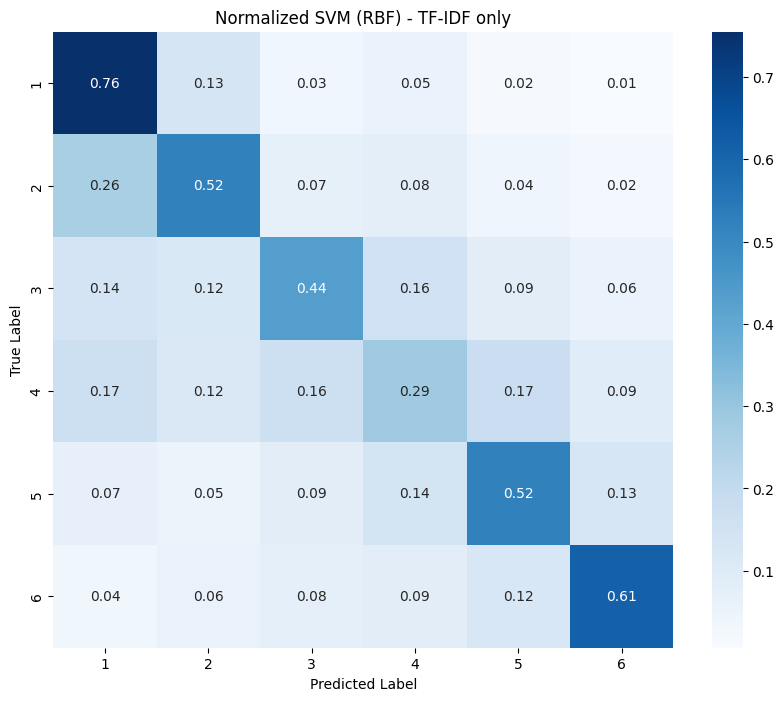

In [ ]:
X= tfidf_matrix.tocsr()
y = df['Readability_Level_Encoded'].values

X_train_Tfidf, X_test_Tfidf, y_train_Tfidf, y_test_Tfidf = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify ensures equal distribution of readability levels
)

print("\nTraining SVM with TF-IDF ...")
svm_Tfidf = SVC(random_state=42)
svm_Tfidf.fit(X_train_Tfidf, y_train_Tfidf)

# Evaluate
y_pred_Tfidf = svm_Tfidf.predict(X_test_Tfidf)
print("\n Model Evaluation (TF-IDF only):")
print(classification_report(y_test_Tfidf, y_pred_Tfidf))

acc_rbf_tfidf = accuracy_score(y_test_Tfidf, y_pred_Tfidf)
qwk_rbf_tfidf = calculate_qwk(y_test_Tfidf, y_pred_Tfidf)
acc1_rbf_tfidf = calculate_accuracy_within_one(y_test_Tfidf, y_pred_Tfidf)

print(f"Accuracy (TF-IDF only): {acc_rbf_tfidf:.4f}")
print(f"QWK (TF-IDF only): {qwk_rbf_tfidf:.4f}")
print(f"Accuracy ±1 (TF-IDF only): {acc1_rbf_tfidf:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_Tfidf, y_pred_Tfidf, class_names_labels, title='SVM (RBF) - TF-IDF only')

Statistical + TF-IDF


Training SVM with Statistical and TF-IDF ...

 Model Evaluation (Statistical and TF-IDF):
              precision    recall  f1-score   support

           0     0.5656    0.8087    0.6656      1547
           1     0.5441    0.5624    0.5531      1547
           2     0.5391    0.4635    0.4984      1547
           3     0.3939    0.3167    0.3511      1547
           4     0.5796    0.5533    0.5661      1547
           5     0.6697    0.6147    0.6411      1547

    accuracy                         0.5532      9282
   macro avg     0.5487    0.5532    0.5459      9282
weighted avg     0.5487    0.5532    0.5459      9282

Accuracy (Statistical and TF-IDF): 0.5532
QWK (Statistical and TF-IDF): 0.7114
Accuracy ±1 (Statistical and TF-IDF): 0.7968


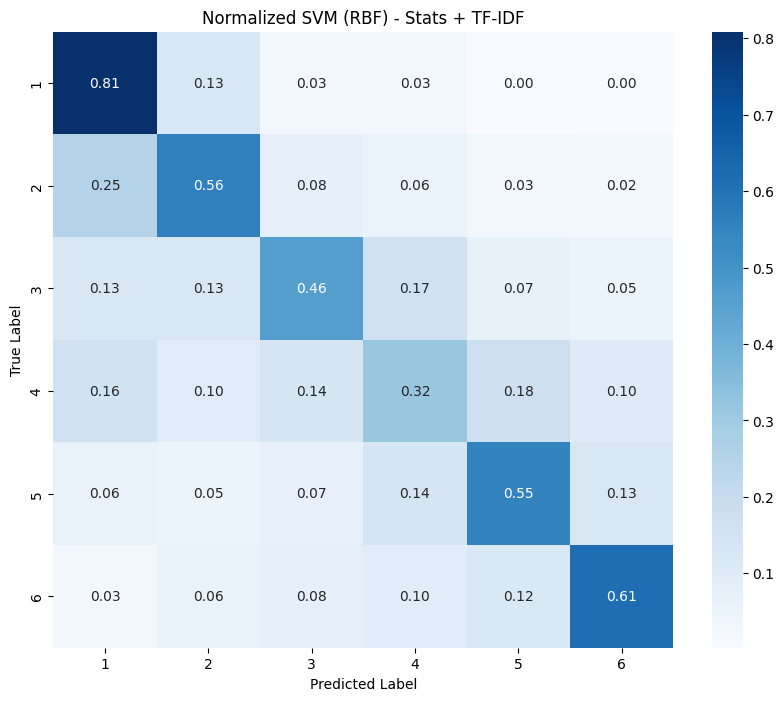

In [ ]:
# Combine all feature matrices: Statistical + TF-IDF
X = hstack([
    X_stats_numeric,
    tfidf_matrix
]).tocsr()
y = df['Readability_Level_Encoded']
X_train_stats_Tfidf, X_test_stats_Tfidf, y_train_stats_Tfidf, y_test_stats_Tfidf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining SVM with Statistical and TF-IDF ...")
svm_stats_Tfidf = SVC(random_state=42)
svm_stats_Tfidf.fit(X_train_stats_Tfidf, y_train_stats_Tfidf)

# Evaluate
y_pred_stats_Tfidf = svm_stats_Tfidf.predict(X_test_stats_Tfidf)
print("\n Model Evaluation (Statistical and TF-IDF):")
print(classification_report(y_test_stats_Tfidf, y_pred_stats_Tfidf, digits=4))

acc_rbf_stats_tfidf = accuracy_score(y_test_stats_Tfidf, y_pred_stats_Tfidf)
qwk_rbf_stats_tfidf = calculate_qwk(y_test_stats_Tfidf, y_pred_stats_Tfidf)
acc1_rbf_stats_tfidf = calculate_accuracy_within_one(y_test_stats_Tfidf, y_pred_stats_Tfidf)

print(f"Accuracy (Statistical and TF-IDF): {acc_rbf_stats_tfidf:.4f}")
print(f"QWK (Statistical and TF-IDF): {qwk_rbf_stats_tfidf:.4f}")
print(f"Accuracy ±1 (Statistical and TF-IDF): {acc1_rbf_stats_tfidf:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_stats_Tfidf, y_pred_stats_Tfidf, class_names_labels, title='SVM (RBF) - Stats + TF-IDF')

### Training with Word2vec

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Word2Vec only


Training Word2Vec model...

Training SVM with Word2Vec features...

 Word2Vec Model Evaluation:
              precision    recall  f1-score   support

           0     0.4958    0.6863    0.5757      1559
           1     0.4754    0.3866    0.4264      1552
           2     0.4075    0.2826    0.3337      1543
           3     0.3238    0.1784    0.2301      1519
           4     0.4442    0.4984    0.4698      1589
           5     0.5023    0.7178    0.5910      1520

    accuracy                         0.4590      9282
   macro avg     0.4415    0.4583    0.4378      9282
weighted avg     0.4418    0.4590    0.4383      9282

Accuracy (Word2Vec): 0.4590
QWK (Word2Vec): 0.6214
Accuracy ±1 (Word2Vec): 0.7182


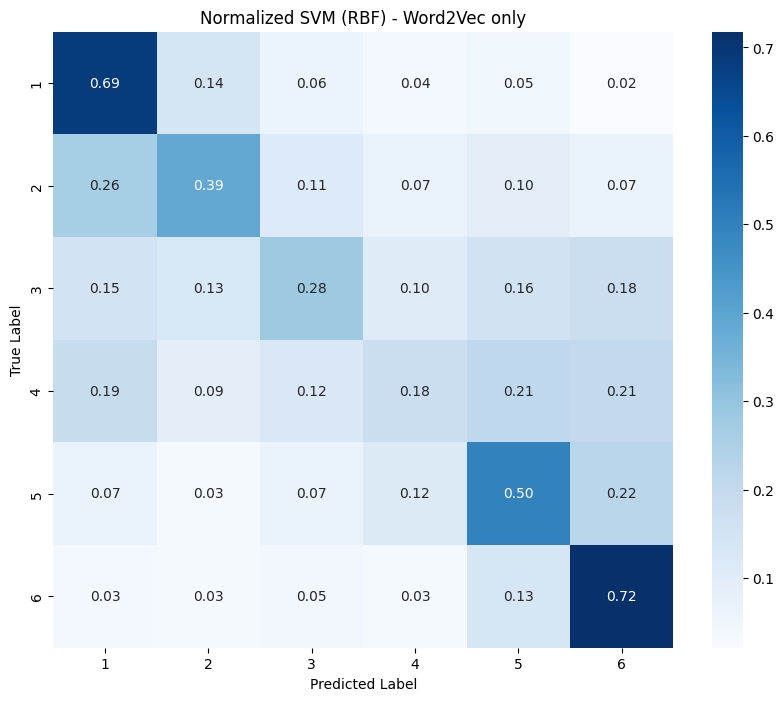

In [ ]:
# Word2Vec Embeddings with default SVC
print("\nTraining Word2Vec model...")
tokenized_sentences = [word_tokenize(text) for text in df['Sentence'].astype(str)]
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)

def get_avg_vector(tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

X_w2v = np.array([get_avg_vector(tokens, w2v_model, 300) for tokens in tokenized_sentences])
y_w2v = df['Readability_Level_Encoded'].values
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.2, random_state=42)

print("\nTraining SVM with Word2Vec features...")
svm_w2v = SVC(random_state=42)
svm_w2v.fit(X_train_w2v, y_train_w2v)

# Evaluate
y_pred_w2v = svm_w2v.predict(X_test_w2v)
print("\n Word2Vec Model Evaluation:")
print(classification_report(y_test_w2v, y_pred_w2v, digits=4))

acc_rbf_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
qwk_rbf_w2v = calculate_qwk(y_test_w2v, y_pred_w2v)
acc1_rbf_w2v = calculate_accuracy_within_one(y_test_w2v, y_pred_w2v)

print(f"Accuracy (Word2Vec): {acc_rbf_w2v:.4f}")
print(f"QWK (Word2Vec): {qwk_rbf_w2v:.4f}")
print(f"Accuracy ±1 (Word2Vec): {acc1_rbf_w2v:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_w2v, y_pred_w2v, class_names_labels, title='SVM (RBF) - Word2Vec only')

Statistical + Word2Vec


Training SVM with Statistical and Word2vec...

 Model Evaluation:(Statistical and Word2vec)
              precision    recall  f1-score   support

           0     0.5173    0.7755    0.6206      1559
           1     0.5073    0.4046    0.4502      1552
           2     0.4152    0.3966    0.4057      1543
           3     0.3700    0.1968    0.2570      1519
           4     0.5274    0.5261    0.5268      1589
           5     0.5636    0.6822    0.6173      1520

    accuracy                         0.4978      9282
   macro avg     0.4835    0.4970    0.4796      9282
weighted avg     0.4839    0.4978    0.4803      9282

Accuracy (Statistical and Word2vec): 0.4978
QWK (Statistical and Word2vec): 0.6783
Accuracy ±1 (Statistical and Word2vec): 0.7585


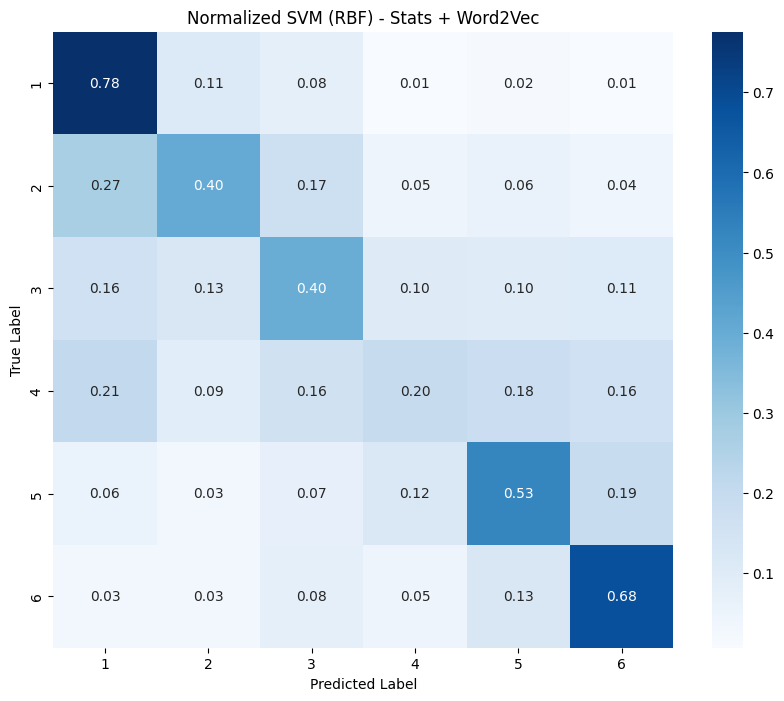

In [ ]:
# Combine Statistical + Word2Vec Features
X_combined = np.hstack([X_stats_numeric, X_w2v])
y_combined = df['Readability_Level_Encoded'].values
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42
)

print("\nTraining SVM with Statistical and Word2vec...")
svm_combined = SVC(random_state=42)
svm_combined.fit(X_train_c, y_train_c)

# Evaluate
y_pred_combined = svm_combined.predict(X_test_c)
print("\n Model Evaluation:(Statistical and Word2vec)")
print(classification_report(y_test_c, y_pred_combined, digits=4))

acc_rbf_stats_w2v = accuracy_score(y_test_c, y_pred_combined)
qwk_rbf_stats_w2v = calculate_qwk(y_test_c, y_pred_combined)
acc1_rbf_stats_w2v = calculate_accuracy_within_one(y_test_c, y_pred_combined)

print(f"Accuracy (Statistical and Word2vec): {acc_rbf_stats_w2v:.4f}")
print(f"QWK (Statistical and Word2vec): {qwk_rbf_stats_w2v:.4f}")
print(f"Accuracy ±1 (Statistical and Word2vec): {acc1_rbf_stats_w2v:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_c, y_pred_combined, class_names_labels, title='SVM (RBF) - Stats + Word2Vec')

### Training with AraBERT Embeddings


Training RBF SVM with AraBERT Embeddings...
Model saved successfully!

 Model Evaluation (RBF SVM - AraBERT):
              precision    recall  f1-score   support

           0     0.6055    0.8145    0.6946      1547
           1     0.6039    0.6070    0.6054      1547
           2     0.4735    0.4557    0.4644      1547
           3     0.4649    0.2915    0.3584      1547
           4     0.5947    0.6251    0.6095      1547
           5     0.7828    0.7899    0.7864      1547

    accuracy                         0.5973      9282
   macro avg     0.5875    0.5973    0.5864      9282
weighted avg     0.5875    0.5973    0.5864      9282

Accuracy (RBF SVM - AraBERT): 0.5973
QWK (RBF SVM - AraBERT): 0.7950
Accuracy ±1 (RBF SVM - AraBERT): 0.8452


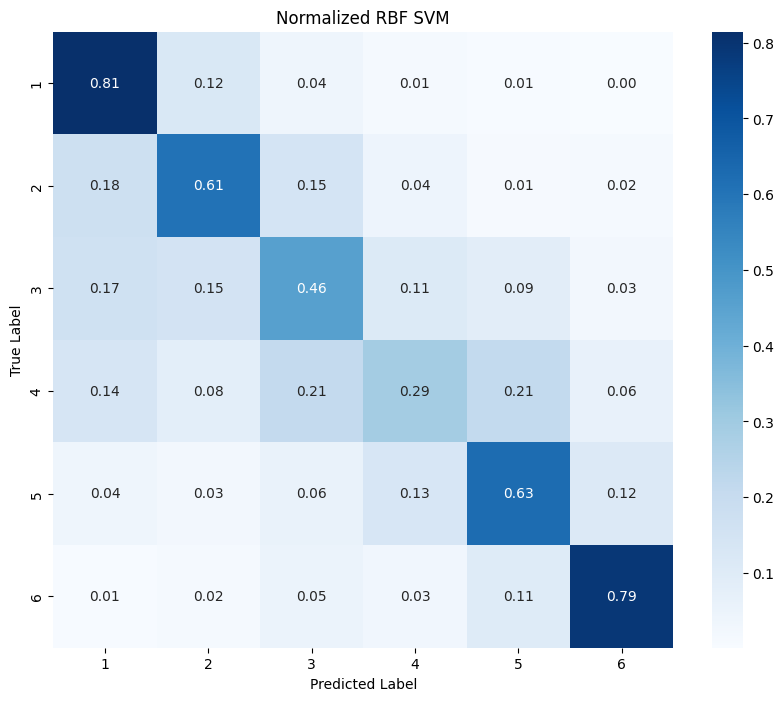

In [ ]:
# Train RBF SVM with AraBERT
print("\nTraining RBF SVM with AraBERT Embeddings...")

svm_ara = SVC(random_state=42)
svm_ara.fit(X_train_pkl, y_train_pkl)

import joblib

# Save the model to a file
joblib.dump(svm_ara, 'svm_arabert_model.pkl')

print("Model saved successfully!")

# Evaluate
y_pred_rbf_ara = svm_ara.predict(X_test_pkl)
print("\n Model Evaluation (RBF SVM - AraBERT):")
print(classification_report(y_test_pkl, y_pred_rbf_ara, digits=4))

acc_rbf_ara = accuracy_score(y_test_pkl, y_pred_rbf_ara)
qwk_rbf_ara = calculate_qwk(y_test_pkl, y_pred_rbf_ara)
acc1_rbf_ara = calculate_accuracy_within_one(y_test_pkl, y_pred_rbf_ara)

print(f"Accuracy (RBF SVM - AraBERT): {acc_rbf_ara:.4f}")
print(f"QWK (RBF SVM - AraBERT): {qwk_rbf_ara:.4f}")
print(f"Accuracy ±1 (RBF SVM - AraBERT): {acc1_rbf_ara:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_pkl, y_pred_rbf_ara, class_names_labels, title='RBF SVM')

## SVM (Linear)

### Training with TF-IDF

TF-IDF only


Training LinearSVC with TF-IDF ...

 Model Evaluation (LinearSVC - TF-IDF only):
              precision    recall  f1-score   support

           0       0.55      0.70      0.61      1547
           1       0.49      0.47      0.48      1547
           2       0.45      0.41      0.43      1547
           3       0.35      0.27      0.30      1547
           4       0.50      0.52      0.51      1547
           5       0.60      0.63      0.62      1547

    accuracy                           0.50      9282
   macro avg       0.49      0.50      0.49      9282
weighted avg       0.49      0.50      0.49      9282

Accuracy (LinearSVC - TF-IDF only): 0.4999
QWK (LinearSVC - TF-IDF only): 0.6616
Accuracy ±1 (LinearSVC - TF-IDF only): 0.7596


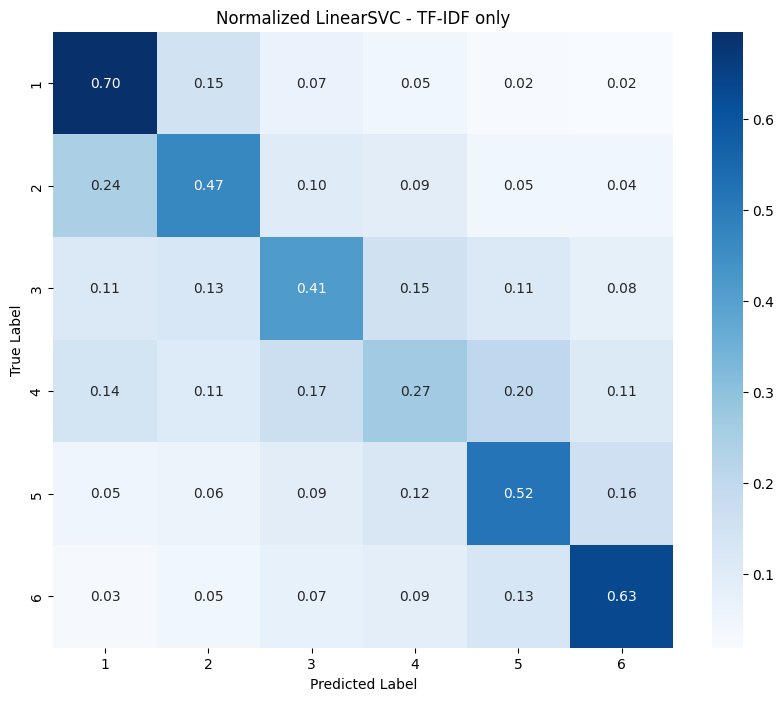

In [ ]:
print("\nTraining LinearSVC with TF-IDF ...")
linear_svm_Tfidf = LinearSVC(random_state=42, dual='auto')
linear_svm_Tfidf.fit(X_train_Tfidf, y_train_Tfidf)

# Evaluate
y_pred_linear_Tfidf = linear_svm_Tfidf.predict(X_test_Tfidf)
print("\n Model Evaluation (LinearSVC - TF-IDF only):")
print(classification_report(y_test_Tfidf, y_pred_linear_Tfidf))

acc_linear_tfidf = accuracy_score(y_test_Tfidf, y_pred_linear_Tfidf)
qwk_linear_tfidf = calculate_qwk(y_test_Tfidf, y_pred_linear_Tfidf)
acc1_linear_tfidf = calculate_accuracy_within_one(y_test_Tfidf, y_pred_linear_Tfidf)

print(f"Accuracy (LinearSVC - TF-IDF only): {acc_linear_tfidf:.4f}")
print(f"QWK (LinearSVC - TF-IDF only): {qwk_linear_tfidf:.4f}")
print(f"Accuracy ±1 (LinearSVC - TF-IDF only): {acc1_linear_tfidf:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_Tfidf, y_pred_linear_Tfidf, class_names_labels, title='LinearSVC - TF-IDF only')

Statistical + TF-IDF


Training LinearSVC with Statistical and TF-IDF ...

 Model Evaluation (LinearSVC - Statistical and TF-IDF):
              precision    recall  f1-score   support

           0       0.58      0.73      0.64      1547
           1       0.49      0.48      0.49      1547
           2       0.47      0.45      0.46      1547
           3       0.35      0.26      0.30      1547
           4       0.52      0.54      0.53      1547
           5       0.62      0.65      0.63      1547

    accuracy                           0.52      9282
   macro avg       0.51      0.52      0.51      9282
weighted avg       0.51      0.52      0.51      9282

Accuracy (LinearSVC - Statistical and TF-IDF): 0.5173
QWK (LinearSVC - Statistical and TF-IDF): 0.6817
Accuracy ±1 (LinearSVC - Statistical and TF-IDF): 0.7717


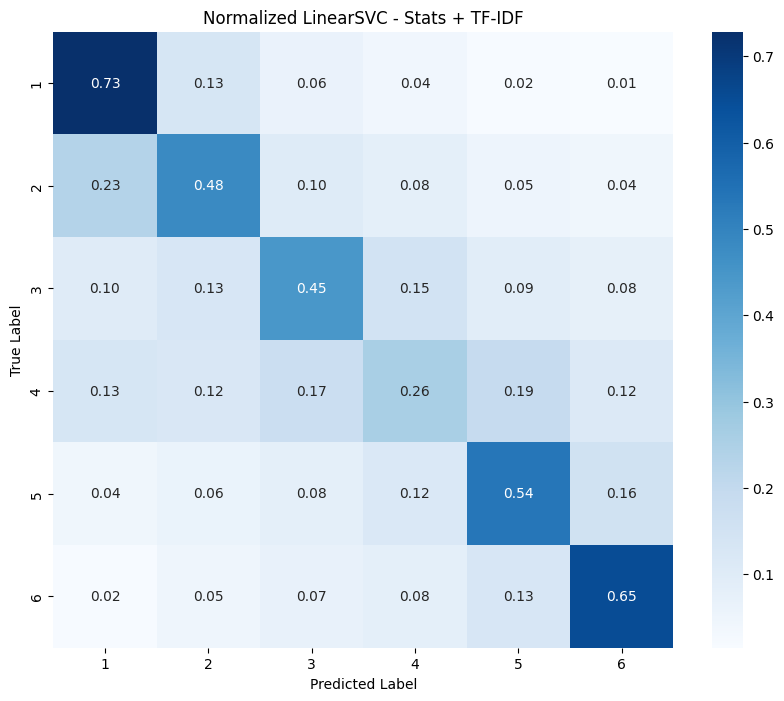

In [ ]:
print("\nTraining LinearSVC with Statistical and TF-IDF ...")
linear_svm_stats_Tfidf = LinearSVC(random_state=42, dual='auto')
linear_svm_stats_Tfidf.fit(X_train_stats_Tfidf, y_train_stats_Tfidf)

# Evaluate
y_pred_linear_stats_Tfidf = linear_svm_stats_Tfidf.predict(X_test_stats_Tfidf)
print("\n Model Evaluation (LinearSVC - Statistical and TF-IDF):")
print(classification_report(y_test_stats_Tfidf, y_pred_linear_stats_Tfidf))

acc_linear_stats_tfidf = accuracy_score(y_test_stats_Tfidf, y_pred_linear_stats_Tfidf)
qwk_linear_stats_tfidf = calculate_qwk(y_test_stats_Tfidf, y_pred_linear_stats_Tfidf)
acc1_linear_stats_tfidf = calculate_accuracy_within_one(y_test_stats_Tfidf, y_pred_linear_stats_Tfidf)

print(f"Accuracy (LinearSVC - Statistical and TF-IDF): {acc_linear_stats_tfidf:.4f}")
print(f"QWK (LinearSVC - Statistical and TF-IDF): {qwk_linear_stats_tfidf:.4f}")
print(f"Accuracy ±1 (LinearSVC - Statistical and TF-IDF): {acc1_linear_stats_tfidf:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_stats_Tfidf, y_pred_linear_stats_Tfidf, class_names_labels, title='LinearSVC - Stats + TF-IDF')

### Training with Word2vec

Word2Vec only


Training LinearSVC with Word2Vec features...

 LinearSVC Word2Vec Model Evaluation:
              precision    recall  f1-score   support

           0       0.45      0.71      0.55      1559
           1       0.47      0.34      0.40      1552
           2       0.46      0.22      0.30      1543
           3       0.29      0.10      0.15      1519
           4       0.41      0.51      0.45      1589
           5       0.43      0.68      0.53      1520

    accuracy                           0.43      9282
   macro avg       0.42      0.43      0.40      9282
weighted avg       0.42      0.43      0.40      9282

Accuracy (LinearSVC - Word2Vec): 0.4287
QWK (LinearSVC - Word2Vec): 0.5323
Accuracy ±1 (LinearSVC - Word2Vec): 0.6659


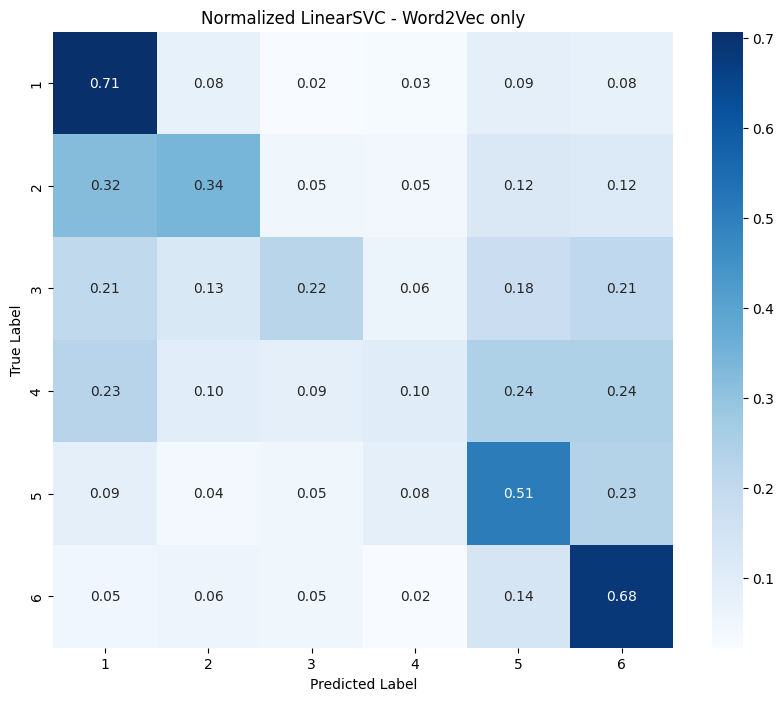

In [ ]:
print("\nTraining LinearSVC with Word2Vec features...")
linear_svm_w2v = LinearSVC(random_state=42, dual='auto')
linear_svm_w2v.fit(X_train_w2v, y_train_w2v)

# Evaluate
y_pred_linear_w2v = linear_svm_w2v.predict(X_test_w2v)
print("\n LinearSVC Word2Vec Model Evaluation:")
print(classification_report(y_test_w2v, y_pred_linear_w2v))

acc_linear_w2v = accuracy_score(y_test_w2v, y_pred_linear_w2v)
qwk_linear_w2v = calculate_qwk(y_test_w2v, y_pred_linear_w2v)
acc1_linear_w2v = calculate_accuracy_within_one(y_test_w2v, y_pred_linear_w2v)

print(f"Accuracy (LinearSVC - Word2Vec): {acc_linear_w2v:.4f}")
print(f"QWK (LinearSVC - Word2Vec): {qwk_linear_w2v:.4f}")
print(f"Accuracy ±1 (LinearSVC - Word2Vec): {acc1_linear_w2v:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_w2v, y_pred_linear_w2v, class_names_labels, title='LinearSVC - Word2Vec only')

Statistical + Word2Vec


Training LinearSVC with Statistical and Word2vec...

 Model Evaluation (LinearSVC - Statistical and Word2vec):
              precision    recall  f1-score   support

           0       0.50      0.85      0.63      1559
           1       0.48      0.38      0.42      1552
           2       0.47      0.28      0.35      1543
           3       0.33      0.11      0.16      1519
           4       0.49      0.58      0.53      1589
           5       0.49      0.68      0.57      1520

    accuracy                           0.48      9282
   macro avg       0.46      0.48      0.44      9282
weighted avg       0.46      0.48      0.45      9282

Accuracy (LinearSVC - Statistical and Word2vec): 0.4816
QWK (LinearSVC - Statistical and Word2vec): 0.6483
Accuracy ±1 (LinearSVC - Statistical and Word2vec): 0.7226


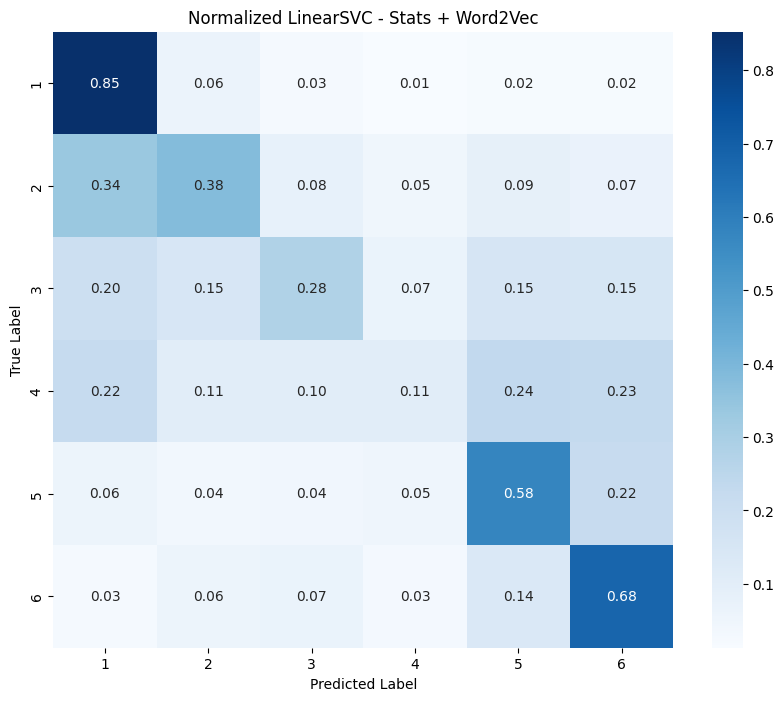

In [ ]:
print("\nTraining LinearSVC with Statistical and Word2vec...")
linear_svm_combined = LinearSVC(random_state=42, dual='auto')
linear_svm_combined.fit(X_train_c, y_train_c)

# Evaluate
y_pred_linear_combined = linear_svm_combined.predict(X_test_c)
print("\n Model Evaluation (LinearSVC - Statistical and Word2vec):")
print(classification_report(y_test_c, y_pred_linear_combined))

acc_linear_combined = accuracy_score(y_test_c, y_pred_linear_combined)
qwk_linear_combined = calculate_qwk(y_test_c, y_pred_linear_combined)
acc1_linear_combined = calculate_accuracy_within_one(y_test_c, y_pred_linear_combined)

print(f"Accuracy (LinearSVC - Statistical and Word2vec): {acc_linear_combined:.4f}")
print(f"QWK (LinearSVC - Statistical and Word2vec): {qwk_linear_combined:.4f}")
print(f"Accuracy ±1 (LinearSVC - Statistical and Word2vec): {acc1_linear_combined:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_c, y_pred_linear_combined, class_names_labels, title='LinearSVC - Stats + Word2Vec')

### Training with AraBERT Embeddings


Training LinearSVC with AraBERT Embeddings...

 Model Evaluation (LinearSVC - AraBERT):
              precision    recall  f1-score   support

           0       0.62      0.80      0.70      1547
           1       0.57      0.60      0.58      1547
           2       0.46      0.39      0.42      1547
           3       0.43      0.25      0.32      1547
           4       0.56      0.61      0.58      1547
           5       0.72      0.81      0.76      1547

    accuracy                           0.58      9282
   macro avg       0.56      0.58      0.56      9282
weighted avg       0.56      0.58      0.56      9282

Accuracy (LinearSVC - AraBERT): 0.5764
QWK (LinearSVC - AraBERT): 0.7723
Accuracy ±1 (LinearSVC - AraBERT): 0.8232


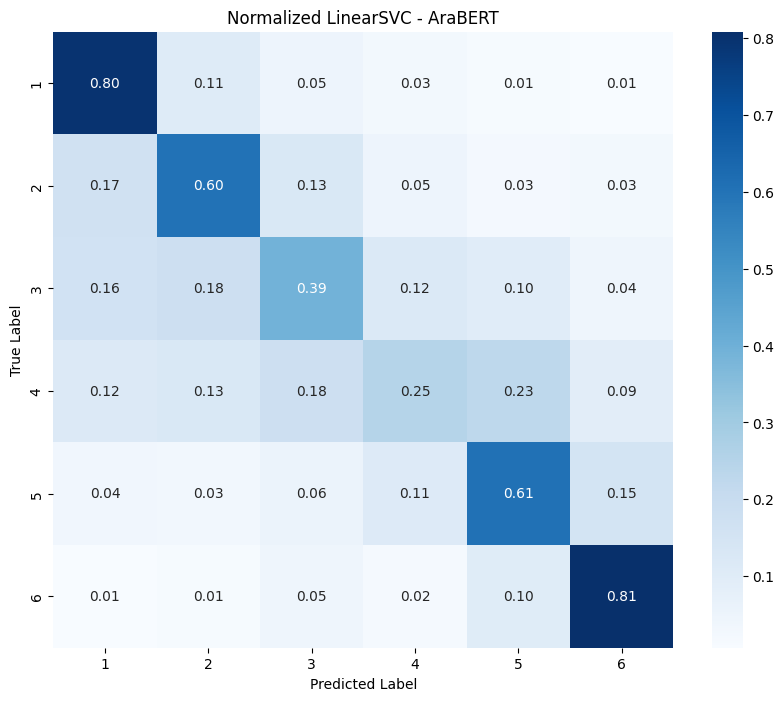

In [ ]:
# Train LinearSVC with AraBERT
print("\nTraining LinearSVC with AraBERT Embeddings...")

linear_svm_ara = LinearSVC(random_state=42, dual='auto')
linear_svm_ara.fit(X_train_pkl, y_train_pkl)

# Evaluate
y_pred_linear_ara = linear_svm_ara.predict(X_test_pkl)
print("\n Model Evaluation (LinearSVC - AraBERT):")
print(classification_report(y_test_pkl, y_pred_linear_ara))

acc_linear_ara = accuracy_score(y_test_pkl, y_pred_linear_ara)
qwk_linear_ara = calculate_qwk(y_test_pkl, y_pred_linear_ara)
acc1_linear_ara = calculate_accuracy_within_one(y_test_pkl, y_pred_linear_ara)

print(f"Accuracy (LinearSVC - AraBERT): {acc_linear_ara:.4f}")
print(f"QWK (LinearSVC - AraBERT): {qwk_linear_ara:.4f}")
print(f"Accuracy ±1 (LinearSVC - AraBERT): {acc1_linear_ara:.4f}")

# Plotting
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_pkl, y_pred_linear_ara, class_names_labels, title='LinearSVC - AraBERT')

## Final Comparison

In [ ]:
import pandas as pd

# Create a dictionary to hold all results, with RBF models grouped
results_data = {
    "Model": [
        "RBF SVM - TF-IDF only",
        "RBF SVM - Stats + TF-IDF",
        "RBF SVM - Word2Vec only",
        "RBF SVM - Stats + Word2Vec",
        "RBF SVM - AraBERT",
        "LinearSVC - TF-IDF only",
        "LinearSVC - Stats + TF-IDF",
        "LinearSVC - Word2Vec only",
        "LinearSVC - Stats + Word2Vec",
        "LinearSVC - AraBERT"
    ],
    "Accuracy": [
        acc_rbf_tfidf,
        acc_rbf_stats_tfidf,
        acc_rbf_w2v,
        acc_rbf_stats_w2v,
        acc_rbf_ara,
        acc_linear_tfidf,
        acc_linear_stats_tfidf,
        acc_linear_w2v,
        acc_linear_combined,
        acc_linear_ara
    ],
    "QWK": [
        qwk_rbf_tfidf,
        qwk_rbf_stats_tfidf,
        qwk_rbf_w2v,
        qwk_rbf_stats_w2v,
        qwk_rbf_ara,
        qwk_linear_tfidf,
        qwk_linear_stats_tfidf,
        qwk_linear_w2v,
        qwk_linear_combined,
        qwk_linear_ara
    ],
    "Accuracy ±1": [
        acc1_rbf_tfidf,
        acc1_rbf_stats_tfidf,
        acc1_rbf_w2v,
        acc1_rbf_stats_w2v,
        acc1_rbf_ara,
        acc1_linear_tfidf,
        acc1_linear_stats_tfidf,
        acc1_linear_w2v,
        acc1_linear_combined,
        acc1_linear_ara
    ]
}

# Create a DataFrame for nice formatting
results_df = pd.DataFrame(results_data)
results_df = results_df.set_index("Model")

# Filter out models that were skipped (i.e., had 0.0 accuracy)
results_df = results_df[results_df['Accuracy'] > 0]


print("--- Final Model Comparison ---")
# Format the DataFrame to 4 decimal places
print(results_df.sort_values(by="QWK", ascending=False).to_string(float_format="%.4f"))

# Find and print the best model based on QWK
print("\n--- Best Model (by QWK) ---")
print(results_df.sort_values(by="QWK", ascending=False).iloc[0])

print("\n--- Best Model (by Accuracy ±1) ---")
print(results_df.sort_values(by="Accuracy ±1", ascending=False).iloc[0])

--- Final Model Comparison ---
                              Accuracy    QWK  Accuracy ±1
Model                                                     
RBF SVM - AraBERT               0.5973 0.7950       0.8452
LinearSVC - AraBERT             0.5764 0.7723       0.8232
LinearSVC - Stats + TF-IDF      0.5173 0.6817       0.7717
RBF SVM - TF-IDF only           0.5225 0.6700       0.7690
LinearSVC - TF-IDF only         0.4999 0.6616       0.7596
LinearSVC - Stats + Word2Vec    0.4816 0.6483       0.7226
RBF SVM - Stats + Word2Vec      0.4365 0.6391       0.7301
RBF SVM - Word2Vec only         0.4581 0.6176       0.7139
RBF SVM - Stats + TF-IDF        0.3655 0.5696       0.7057
LinearSVC - Word2Vec only       0.4287 0.5323       0.6659

--- Best Model (by QWK) ---
Accuracy       0.597285
QWK            0.795042
Accuracy ±1    0.845184
Name: RBF SVM - AraBERT, dtype: float64

--- Best Model (by Accuracy ±1) ---
Accuracy       0.597285
QWK            0.795042
Accuracy ±1    0.845184
Name: RBF S


--- Starting GridSearchCV for RBF SVM (AraBERT) ---
Fitting grid search (optimizing for Accuracy)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy score: 0.6078

--- Evaluating Tuned RBF SVM (AraBERT) on Test Set ---

Model Evaluation (Tuned RBF SVM - AraBERT):
              precision    recall  f1-score   support

           0       0.65      0.82      0.73      1547
           1       0.63      0.62      0.62      1547
           2       0.50      0.49      0.50      1547
           3       0.47      0.35      0.40      1547
           4       0.61      0.62      0.61      1547
           5       0.81      0.79      0.80      1547

    accuracy                           0.62      9282
   macro avg       0.61      0.62      0.61      9282
weighted avg       0.61      0.62      0.61      9282

Accuracy (Tuned AraBERT): 0.6178
QWK (Tuned AraBERT): 0.8070
Accuracy ±1 (Tuned AraBERT): 0.85

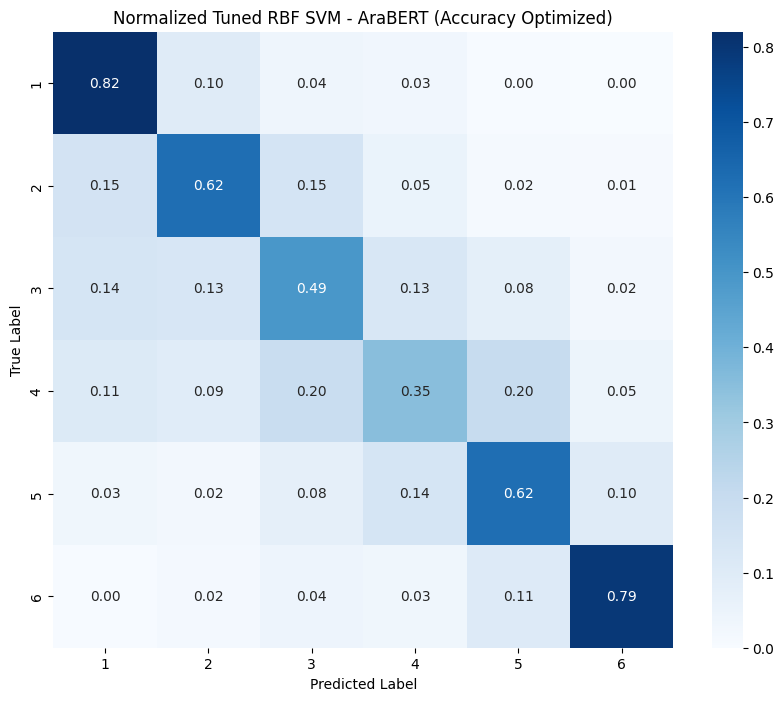

In [ ]:
# --- GridSearchCV for RBF SVM (AraBERT) ---
print("\n--- Starting GridSearchCV for RBF SVM (AraBERT) ---")

param_grid = {
    'C': [10, 100],
    'gamma': [1, 'scale'],
    'kernel': ['rbf']
}

# Initialize GridSearchCV
print("Fitting grid search (optimizing for Accuracy)...")
grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on the AraBERT training data
grid_search.fit(X_train_pkl, y_train_pkl)

# Get the best model found by the search
best_svm_ara_tuned = grid_search.best_estimator_

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best CV Accuracy score: {grid_search.best_score_:.4f}")

# Evaluate the Tuned Model
print("\n--- Evaluating Tuned RBF SVM (AraBERT) on Test Set ---")
y_pred_rbf_ara_tuned = best_svm_ara_tuned.predict(X_test_pkl)

print("\nModel Evaluation (Tuned RBF SVM - AraBERT):")
print(classification_report(y_test_pkl, y_pred_rbf_ara_tuned))

# Calculate and store metrics for the final comparison
acc_rbf_ara_tuned = accuracy_score(y_test_pkl, y_pred_rbf_ara_tuned)
qwk_rbf_ara_tuned = calculate_qwk(y_test_pkl, y_pred_rbf_ara_tuned)
acc1_rbf_ara_tuned = calculate_accuracy_within_one(y_test_pkl, y_pred_rbf_ara_tuned)

print(f"Accuracy (Tuned AraBERT): {acc_rbf_ara_tuned:.4f}")
print(f"QWK (Tuned AraBERT): {qwk_rbf_ara_tuned:.4f}")
print(f"Accuracy ±1 (Tuned AraBERT): {acc1_rbf_ara_tuned:.4f}")

# Plot confusion matrix
class_names_labels = target_le.classes_
plot_normalized_confusion_matrix(y_test_pkl, y_pred_rbf_ara_tuned, class_names_labels, title='Tuned RBF SVM - AraBERT (Accuracy Optimized)')

# Feature Importance

In [ ]:
# We will analyze the feature importances from the
# 'LinearSVC - Statistical and TF-IDF' model (linear_svm_stats_Tfidf)

# 1. Get the statistical feature names]
stat_feature_names = ['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']

# 2. Get the TF-IDF feature names (from 'tfidf_vectorizer')
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 3. Combine all feature names in the correct order
all_feature_names = np.concatenate([stat_feature_names, tfidf_feature_names])

# 4. Get the coefficients (importances) from the trained model
# The shape is (n_classes, n_features)
model_coefs = linear_svm_stats_Tfidf.coef_

# 5. Get the class names (from 'target_le')
class_names = target_le.classes_

print(f"Feature coefficients shape: {model_coefs.shape}")
print(f"Total features: {len(all_feature_names)}")

# --- Function to display top features per class ---
def get_top_features_per_class(coefs, features, class_labels, top_n=15):
    results = {}
    for i, label in enumerate(class_labels):
        # Get coefficients for this specific class
        class_coef = coefs[i]

        # Get top positive (indicators FOR this class)
        # np.argsort returns indices from smallest to largest
        top_positive_indices = np.argsort(class_coef)[-top_n:]
        top_positive_features = [features[j] for j in top_positive_indices]
        top_positive_values = [class_coef[j] for j in top_positive_indices]

        # Get top negative (indicators AGAINST this class)
        top_negative_indices = np.argsort(class_coef)[:top_n]
        top_negative_features = [features[j] for j in top_negative_indices]
        top_negative_values = [class_coef[j] for j in top_negative_indices]

        results[label] = {
            "top_positive_features": list(zip(top_positive_features, top_positive_values)),
            "top_negative_features": list(zip(top_negative_features, top_negative_values))
        }
    return results

# Get and print the top features
top_features_results = get_top_features_per_class(model_coefs, all_feature_names, class_names, top_n=15)

for label, data in top_features_results.items():
    print(f"\n--- Top Features for Readability Level: {label} ---")
    print("\nTop Positive (Indicators FOR this level):")
    # Iterate in reverse to show highest importance first
    for feature, value in reversed(data['top_positive_features']):
        print(f"  {feature}: {value:.4f}")

    print("\nTop Negative (Indicators AGAINST this level):")
    # Iterate normally to show lowest importance (most negative) first
    for feature, value in data['top_negative_features']:
        print(f"  {feature}: {value:.4f}")

Feature coefficients shape: (6, 5004)
Total features: 5004

--- Top Features for Readability Level: 1 ---

Top Positive (Indicators FOR this level):
  مقابلة: 1.9184
  نعم لا: 1.7737
  أردن: 1.6944
  بشرة: 1.6542
  ٱلتزم: 1.6294
  نمل: 1.6233
  الله رسول: 1.6197
  إزالة: 1.5938
  ريف: 1.5658
  وارد في: 1.5574
  من منزل: 1.4314
  من حق: 1.4211
  أطاع: 1.4004
  من فضل: 1.3963
  مسلم في: 1.3859

Top Negative (Indicators AGAINST this level):
  الذي: -4.7229
  يا: -4.5271
  كان: -4.1554
  ثم: -3.8504
  قد: -3.6577
  إن: -3.5003
  لا: -3.4487
  ليس: -3.0504
  لكن: -2.6901
  أصبح: -2.4647
  أن: -2.3808
  سوف: -2.3400
  ذو: -2.0208
  لم: -1.9527
  أو: -1.8899

--- Top Features for Readability Level: 2 ---

Top Positive (Indicators FOR this level):
  مخلوق حي: 3.3488
  يتم: 3.1009
  يا: 2.3429
  سؤال تالي: 2.0576
  سعودي: 1.9759
  لا أحد: 1.9188
  معلومة: 1.8388
  من بين: 1.8110
  فخار: 1.7288
  هندسي: 1.6139
  سوف: 1.5625
  سائح: 1.5475
  فنان: 1.4658
  زخرفة: 1.4514
  تمسك: 1.4493

Top Negati

In [ ]:
print("\nGlobal Feature Importance (Non-TFIDF Features):")

# Get the coefficients from the same model (trained on stats + tfidf)
model_coefs = linear_svm_stats_Tfidf.coef_

# Calculate the mean absolute value across all classes (axis=0)
# This gives one importance score per feature
global_importances = np.mean(np.abs(model_coefs), axis=0)

# Get the names of the statistical features
feature_names_stats = ['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']
num_stats_features = len(feature_names_stats)

# Get importances for just the first N statistical features
stats_importances = global_importances[:num_stats_features]

# Create a Series for easy sorting and display
importance_df = pd.Series(
    stats_importances,
    index=feature_names_stats
).sort_values(ascending=False)

print(importance_df)


Global Feature Importance (Non-TFIDF Features):
Morph_Complexity    0.564379
Lexical_Density     0.419730
Avg_Lex_Length      0.164205
Word_Count          0.021668
dtype: float64
